# [NTDS'18] milestone 3: spectral graph theory
[ntds'18]: https://github.com/mdeff/ntds_2018

[Michaël Defferrard](http://deff.ch), [EPFL LTS2](https://lts2.epfl.ch)

## Students

* Team: `28`
* Students: `Guillain, Léonore Valentine; Pase, Francesco; Rusu, Cosmin-Ionut; Zhuang, Ying`
* Dataset: `Flight Routes`

## Rules

* Milestones have to be completed by teams. No collaboration between teams is allowed.
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart & Run All" in Jupyter.

## Objective

The goal of this milestone is to get familiar with the graph Laplacian and its spectral decomposition.

## 0 Load your network

In [1]:
%matplotlib inline

If you get a `No module named 'sklearn'` error when running the below cell, install [scikit-learn](https://scikit-learn.org) with `conda install scikit-learn` (after activating the `ntds_2018` environment).

In [2]:
import numpy as np
from scipy import sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

Let's denote your graph as $\mathcal{G} = (\mathcal{V}, \mathcal{E}, A)$, where $\mathcal{V}$ is the set of nodes, $\mathcal{E}$ is the set of edges, $A \in \mathbb{R}^{N \times N}$ is the (weighted) adjacency matrix, and $N = |\mathcal{V}|$ is the number of nodes.

Import the adjacency matrix $A$ that you constructed in the first milestone.
(You're allowed to update it between milestones if you want to.)

In [3]:
adjacency = np.load('adjacency.npy') # the adjacency matrix
n_nodes =  adjacency.shape[0] # the number of nodes in the network

## 1 Graph Laplacian

### Question 1

From the (weighted) adjacency matrix $A$, compute both the combinatorial (also called unnormalized) and the normalized graph Laplacian matrices.

Note: if your graph is weighted, use the weighted adjacency matrix. If not, use the binary adjacency matrix.

For efficient storage and computation, store these sparse matrices in a [compressed sparse row (CSR) format](https://en.wikipedia.org/wiki/Sparse_matrix#Compressed_sparse_row_.28CSR.2C_CRS_or_Yale_format.29).

In [4]:
def compute_laplacian(adjacency):
    """Computes the laplacian given the adjacency matrix"""
    degrees = adjacency.sum(axis=1)
    
    #Compute D and D^-1/2
    D = np.diag(degrees)
    D_inv_sqrt = scipy.sparse.csc_matrix(np.diag(1 / (np.sqrt(degrees))))


    laplacian_combinatorial =  scipy.sparse.csr_matrix(D - adjacency)
    laplacian_normalized =  scipy.sparse.csr_matrix.dot(D_inv_sqrt, scipy.sparse.csr_matrix.dot(laplacian_combinatorial, D_inv_sqrt))
    return laplacian_normalized, laplacian_combinatorial, D_inv_sqrt
    
laplacian_normalized, laplacian_combinatorial, D_inv_sqrt = compute_laplacian(adjacency)

Use one of them as the graph Laplacian $L$ for the rest of the milestone.
We however encourage you to run the code with both to get a sense of the difference!

In [5]:
laplacian =  laplacian_normalized # Either laplacian_combinatorial or laplacian_normalized.

### Question 2

Compute the eigendecomposition of the Laplacian $L = U^\top \Lambda U$, where the columns $u_k \in \mathbb{R}^N$ of $U = [u_1, \dots, u_N] \in \mathbb{R}^{N \times N}$ are the eigenvectors and the diagonal elements $\lambda_k = \Lambda_{kk}$ are the corresponding eigenvalues.

Make sure that the eigenvalues are ordered, i.e., $0 = \lambda_1 \leq \lambda_2 \leq \dots \leq \lambda_N$.

In [162]:
#We comparse different methods & choose the most appropoiate one
#%timeit np.linalg.eig(laplacian.toarray())

In [163]:
#%timeit scipy.linalg.eig(laplacian.toarray())

In [164]:
#takes way too long to run
#%timeit scipy.sparse.linalg.eigs(laplacian.asfptype(), k=n_nodes-2)

In [165]:
#matrix is symetric
#print(f'Our matrix is symetric: {np.allclose(adjacency, adjacency.T)}')
#%timeit scipy.sparse.linalg.eigsh(laplacian.asfptype(), n_nodes-2)

In [166]:
#%timeit np.linalg.eigh(laplacian.toarray())

In [167]:
#%timeit scipy.linalg.eigh(laplacian.toarray())

In [6]:
eigenvalues, eigenvectors =  np.linalg.eigh(laplacian.toarray())
indexes_sorted = np.argsort(eigenvalues)
eigenvalues_sorted = np.sort(eigenvalues)
eigenvector_sorted = eigenvectors[:,indexes_sorted]

assert eigenvectors.shape == (n_nodes, n_nodes)

Justify your choice of eigensolver.

**Your answer here.**

We use the numpy eigensolver for symetric matrixes (and so using dense matrix) because it is the fastest and has the most stable results. The scipy.sparse's implementatios $\textit{scipy.sparse.linalg.eigs()}$ and $ \textit{scipy.sparse.linalg.eigsh()}$ are not able compute all the $\textit{n_nodes}$ eigenvectors.

### Question 3

We can write $L = S S^\top$. What is the matrix $S$? What does $S^\top x$, with $x \in \mathbb{R}^N$, compute?

**Your answer here.**

The matrix $S \in \mathbb{R}^{N \times M}$, where $M = |\mathcal{E}|$ and $N = |\mathcal{V}|$, is the Incidence Matrix of the (directed) graph such that:

 \begin{equation}
    S(i,j) =
    \begin{cases}
      +1, & \text{if}\ \exists k : e_j = (v_i, v_k) \in \mathcal{E} \\
      -1, & \text{if}\ \exists k : e_j = (v_k, v_i) \in \mathcal{E} \\
      0, & \text{otherwise}
    \end{cases}
  \end{equation}
  
If we think of $x \in \mathbb{R}^N$ as a function defined in the graph space (every vertexof the graph is a point of the Domain), the value $S^\top x \in S^M$ denotes the gradient of $x$ over the $M$ edges. Indeed $(S^\top x)_j = \sum_h S^\top(j, h) \cdot x_h =  x_i - x_k$ (where pedix $y$ denotes the the y-th element of a vector and j is the edge connecting node $i$ to $k$) is the difference of the function computed in two closed points of the graph. The direction toward which the gradient is computed is indicated by the direction of the edge connecting the nodes ($\textit{oriented Incidence Matrix}$).


### Question 4

Show that $\lambda_k = \| S^\top u_k \|_2^2$, where $\| \cdot \|_2^2$ denotes the squared Euclidean norm (a.k.a. squared $L^2$ norm).

**Your answer here.**
We can easily see that:
$$
 \| S^\top u_k \|_2^2 = < (S^\top u_k)^T, S^\top u_k > = < u_k^T S, S^\top u_k > = u_k^T SS^\top u_k = u_k^T L u_k = \lambda_k u_k^Tu_k = \lambda_k
$$
because of definition of Euclidian norm and because the eigenvectors decomposition finds orthonormal vectors.

What does the quantity $\| S^\top x \|_2^2$ tell us about $x$?

**Your answer here.**
By definition of Euclidian norm and answer of question 3 we have $\| S^\top x \|_2^2 = \sum_{i\sim k}(x_i - x_k)^2$ that's an indication of the smoothness of the function $x$. We can notice that, if the graph is weighted, $\| S^\top x \|_2^2 = \sum_{i\sim k}w_{i,k}(x_i - x_k)^2$, where $w_{i,k}$ is the weight of the edge j. Given this, $\| S^\top x \|_2^2 = x^TLx$ accumultes all the squared variations of the function along all the edges (positive values) given an indication of how fast the function varies over the network.

### Question 5

What is the value of $u_0$, both for the combinatorial and normalized Laplacians?

Number of nonzero elements in the first eigenvector : 3154


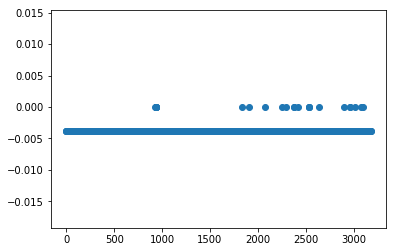

In [7]:
#We multiply u0 by D^(-1/2) to level all the nonzero elements of the vector
plt.scatter(np.arange(eigenvalues.shape[0]), D_inv_sqrt.toarray() @ eigenvector_sorted[:,1])

print("Number of nonzero elements in the first eigenvector :", sum(eigenvector_sorted[:,1]<-0.00001))

**Your answer here.**

As we saw in class, the first eigenvector $\textbf{u}_0$ for the combinatorial laplacian lies along the direction of the vector $\textbf{1}$ (it is not exactly the $\textbf{one}$ vector because of the eigensolver) if the network presents a single connected components. For the normalized laplacian, it is the same vector where each component is rescaled by the squared root of the degree of such component (node). In our case, given that our network is not a signle connected component, $\textbf{u}_0$ is a signal function indicating one of the isolated component.

### Question 6

Look at the spectrum of the Laplacian by plotting the eigenvalues.
Comment on what you observe.

In [8]:
eigenvalues_sorted[-1] 
print(np.max(np.sum(np.where(adjacency>1, 1,0), axis=1)))

185


Text(0, 0.5, 'Value')

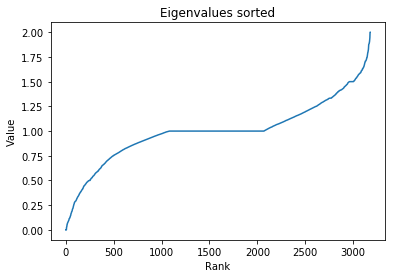

In [9]:
plt.plot( eigenvalues_sorted)
plt.title("Eigenvalues sorted")
plt.xlabel("Rank")
plt.ylabel("Value")

Sum of eigenvalues is : 3179.0


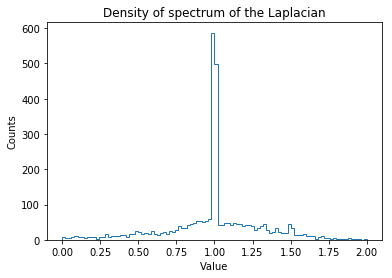

In [10]:
plt.hist(eigenvalues_sorted, histtype='step', bins=100, log=False)
plt.title("Density of spectrum of the Laplacian")
plt.xlabel("Value")
plt.ylabel("Counts")
#It should be equals to the number of nodes, and it is
print("Sum of eigenvalues is :" , np.sum(eigenvalues_sorted))


**Your answer here.**

For the normalized laplacian, the sum of the eigenvalues is equal to the number of nodes in the graph, consequently the distribution of such values has this constraint. The density of the spectrum is very interesting because it reveals about the sctructure of our graph. The shape of the density is an indication that our network is scale-free, as described in [paper link](http://ceec.fnts.bg/telecom/2017/documents/CD2017/Papers/9.pdf).




How many connected components are there in your graph? Answer using the eigenvalues only.

Text(0.5, 0, 'Index')

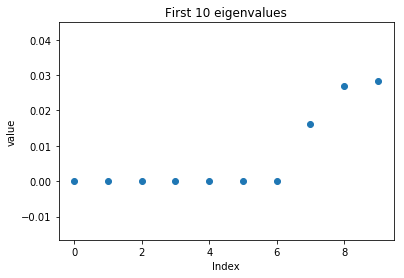

In [11]:
#We scatter the first 10 to see the connected components
plt.scatter(np.arange(10), eigenvalues_sorted[0:10])
plt.title("First 10 eigenvalues")
plt.ylabel("value")
plt.xlabel("Index")

**Your answer here.**

In our network we have 7 connected components. We can infer this by looking at the algebraic multiplicity of the eigenvalues zero that's equal to the number of connected components. This is true for both the matrices.

Is there an upper bound on the eigenvalues, i.e., what is the largest possible eigenvalue? Answer for both the combinatorial and normalized Laplacians.

**Your answer here.**

For both the matrices the minimum value is zero, indeed they're positive semidefinite. Then, given that we used the normalized laplacian, the largest possible eigenvalue is 2. For the combinatorial case, the largest eigenvalue is clearely upper bounded by the fact that, for any matrix, the sum of the eigenvalues is equal to the Trace of the matrix. For the laplacian matrices, this is twice the number of edges of the graph. Reasearching we found that as a consequence of the [Gershgorin's Theorem](https://en.wikipedia.org/wiki/Gershgorin_circle_theorem) the largest eigenvalue $\lambda_n$ is at most twice the maximum vertex degree.

## 3 Laplacian eigenmaps

*Laplacian eigenmaps* is a method to embed a graph $\mathcal{G}$ in a $d$-dimensional Euclidean space.
That is, it associates a vector $z_i \in \mathbb{R}^d$ to every node $v_i \in \mathcal{V}$.
The graph $\mathcal{G}$ is thus embedded as $Z \in \mathbb{R}^{N \times d}$.

### Question 7

What do we use Laplacian eigenmaps for? (Or more generally, graph embeddings.)

**Your answer here.**

It is used to preform dimensionality reduction: go from high dimensional datapoints to a lower dimensional equivalent, while preserving similarities (locality preservation) in among the datapoints.

### Question 8

Embed your graph in $d=2$ dimensions with Laplacian eigenmaps.
Try with and without re-normalizing the eigenvectors by the degrees, then keep the one your prefer.

**Recompute** the eigenvectors you need with a partial eigendecomposition method for sparse matrices.
When $k \ll N$ eigenvectors are needed, partial eigendecompositions are much more efficient than complete eigendecompositions.
A partial eigendecomposition scales as $\Omega(k |\mathcal{E}|$), while a complete eigendecomposition costs $\mathcal{O}(N^3)$ operations.

In [12]:
#calculate largest component to use for later
eig_v = (D_inv_sqrt.toarray() @ eigenvector_sorted)[:,0:7]
mean = np.median(eig_v, axis=0)
indixes = np.where(abs(eig_v-mean) < 1e-10, 1, 0)

mask_largest_component = indixes.T[np.argmin(indixes.sum(axis=0))]


In [13]:
#recomputing eigendecomposition
laplacian_normalized_, laplacian_combinatorial_, D_inv_sqrt_ = compute_laplacian(
    adjacency[mask_largest_component > 0][:, mask_largest_component > 0])

Plot the nodes embedded in 2D. Comment on what you see.

In [20]:
#EIGHS SOLVER
eigen_val, eigen_vec = scipy.sparse.linalg.eigsh(
    scipy.sparse.csc_matrix(laplacian_normalized_).asfptype(), 10, which='SM')

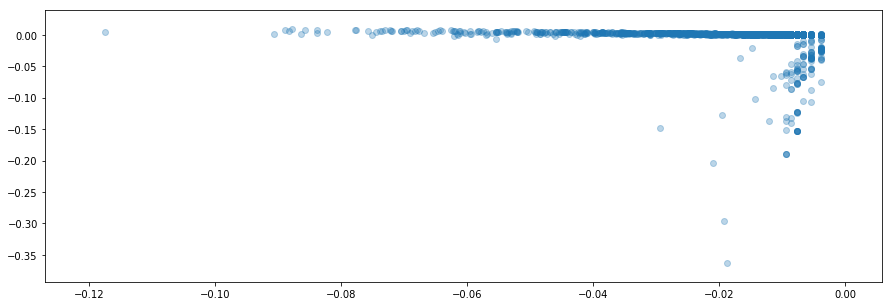

In [21]:
plt.figure(figsize=(15,5))
plt.scatter( eigen_vec[:,0], eigen_vec[:,1], alpha=0.3)

**Your answer here.**

We can observe that most of the nodes have similar positions leading to overlap in the plot, indicating that our network is pretty dense. We see also very few outlier nodes. The "L" shape of our eigenmap shows that most nodes have zero along the Y-axis; then we have some nodes that have non-zeros along Y-axis and small values along the X-axis. Thus we hypothesis that our network can be splitted into 2 components.

### Question 9

What does the embedding $Z \in \mathbb{R}^{N \times d}$ preserve?

**Your answer here.**


As stated before, the embedding procedure preserves local similarity between points mapping linking similarities (graph topology) to euclidean proximity.

## 2 Spectral clustering

*Spectral clustering* is a method to partition a graph into distinct clusters.
The method associates a feature vector $z_i \in \mathbb{R}^d$ to every node $v_i \in \mathcal{V}$, then runs [$k$-means](https://en.wikipedia.org/wiki/K-means_clustering) in the embedding space $\mathbb{R}^d$ to assign each node $v_i \in \mathcal{V}$ to a cluster $c_j \in \mathcal{C}$, where $k = |\mathcal{C}|$ is the number of desired clusters.

### Question 10

Choose $k$ and $d$. How did you get to those numbers?

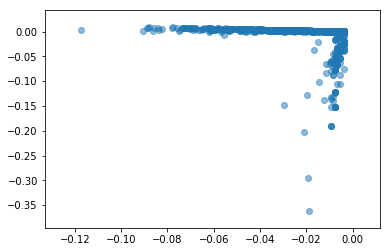

In [22]:
#Biggest Component adjacency matrix
biggest_component = adjacency[mask_largest_component > 0][:, mask_largest_component > 0]

#Compute laplacian and eigendecomposition of the filtered graph
laplacian_normalized_filtered, laplacian_combinatorial_filtered, D_inv_sqrt_filtered = compute_laplacian( biggest_component)
filter_eigen_val, filter_eigen_vec = np.linalg.eigh(laplacian_normalized_filtered.toarray())

indexes_sorted = np.argsort(filter_eigen_val)
filter_eigen_val = np.sort(filter_eigen_val)
filter_eigen_vec = filter_eigen_vec[:,indexes_sorted]


plt.scatter(filter_eigen_vec[:,0],filter_eigen_vec[:,1], alpha=0.5)


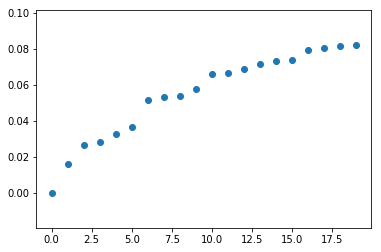

In [23]:
plt.scatter(np.arange(20), filter_eigen_val[0:20])

**Your answer here.**

$k$ is the number of clusters we will get, $d$ is the dimensionality of our datapoints. We chose $d$ as to maximize the gap between two consecutive eigenvalues. As we can see on the above plot we have smooth transitions among the eigenvalues but 6 and 2 have the largest gaps, however we used 2 beacause of the curse of dimensionality (clustering in higher dimensions is tougher) and taking into consideration the small amount of datapoints we have.

By looking at the plot in 2-dimension, we decided to split our graph in 2 components (X and Y axis).

### Question 11

1. Embed your graph in $\mathbb{R}^d$ as $Z \in \mathbb{R}^{N \times d}$.
   Try with and without re-normalizing the eigenvectors by the degrees, then keep the one your prefer.
1. If you want $k=2$ clusters, partition with the Fiedler vector. For $k > 2$ clusters, run $k$-means on $Z$. Don't implement $k$-means, use the `KMeans` class imported from scikit-learn.

In [149]:
#We want 2 clusters, so we use the Fiedler Vector
labels = np.where(filter_eigen_vec[:,1] > 0, 1, 0)

In [140]:
kmeans = KMeans(n_clusters=10)
# Normalized vectors and Fitting the input data
kmeans = kmeans.fit(filter_eigen_vec[:,:2])
# Getting the cluster labels
labels = kmeans.predict(filter_eigen_vec[:,:2])

In [150]:
#checking how many nodes are in each cluster
d = {}
for label in labels:
    if label not in d.keys():
        d[label] = 1
    else :
        d[label] += 1
print("Size of Clusters: ", d)

Size of Clusters:  {1: 2962, 0: 192}


### Question 12

Use the computed cluster assignment to reorder the adjacency matrix $A$.
What do you expect? What do you observe?

In [151]:
# Your code here.
#we sort the list (label, index of node) and the retrive the index
L = [ (labels[i],i) for i in np.arange(len(labels)) ]
L.sort()

In [152]:
reorder = [i for l, i in L]

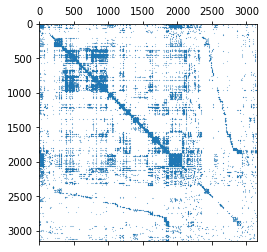

In [153]:
plt.spy(adjacency[reorder][:, reorder], markersize=0.1)

**Your answer here.**

We expect to see a quasi-diagonal matrix, but given the density of our components it is not easy to isolate good clusters. We can observe a big block component along the diagonal that represents the most connected part of our network (with our hubs) and poorely connected nodes on the lower-right corner.

### Question 13

If you have ground truth clusters for your dataset, compare the cluster assignment from spectral clustering to the ground truth.
A simple quantitative measure is to compute the percentage of nodes that have been correctly categorized.
If you don't have a ground truth, qualitatively assess the quality of the clustering.

Ground truth clusters are the "real clusters".
For example, the genre of musical tracks in FMA, the category of Wikipedia articles, the spammer status of individuals, etc.
Look for the `labels` in the [dataset descriptions](https://github.com/mdeff/ntds_2018/tree/master/projects/README.md).

**answer**

While we don't have a ground truth label, our nodes correspond to airports and thus are embedded on a 2D hyperplane in 3D. We check for fun if our clustering corresponds to something on the map by overlapping lattitudes.

In [154]:
import pandas as pd
features = pd.read_csv("features.csv", index_col=0)
locations = np.array(features[mask_largest_component > 0].apply(lambda x : [x.Latitude, x.Longitude], axis=1).tolist())

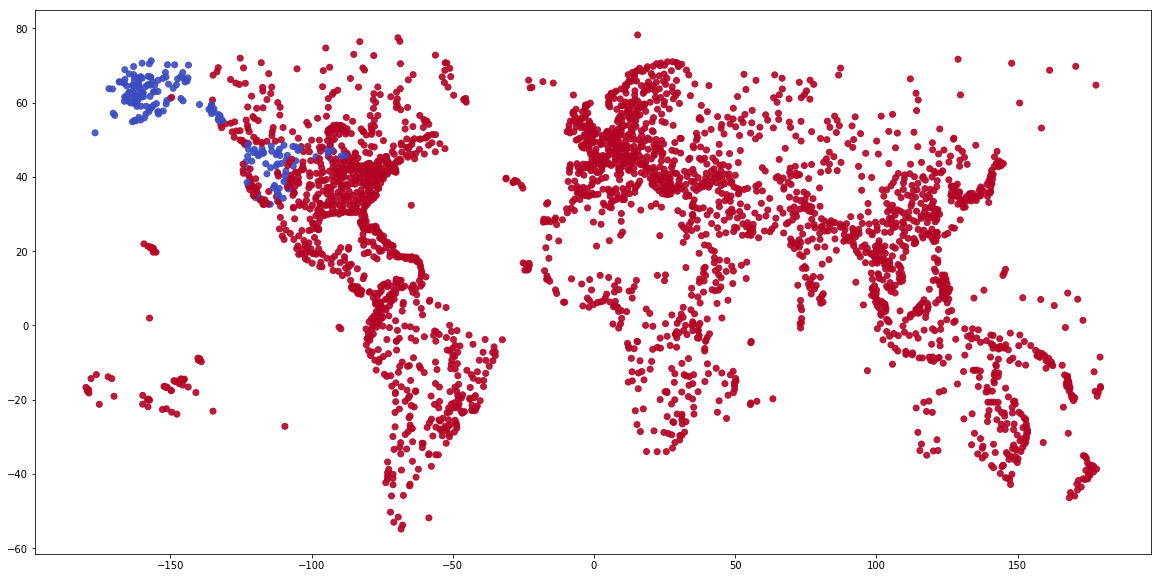

In [160]:
plt.figure(figsize=(20, 10))
plt.scatter(locations[:,1], locations[:,0], alpha=0.9, cmap=plt.cm.coolwarm, c=labels)

### Question 14

Plot the cluster assignment (one color per cluster) on the 2D embedding you computed above with Laplacian eigenmaps.

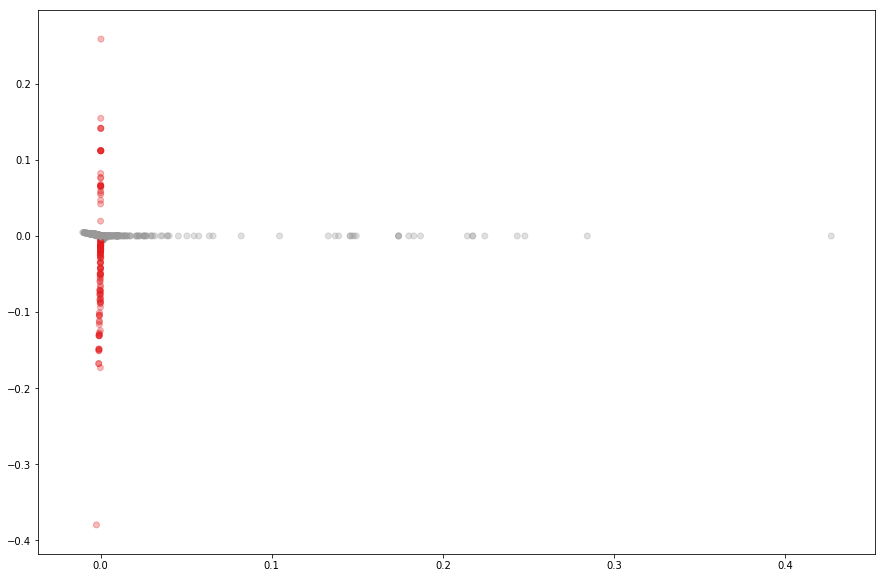

In [45]:
#move code from above here
plt.figure(figsize=(15, 10))
plt.scatter(filter_eigen_vec[:,4], filter_eigen_vec[:,3], alpha=0.3, cmap=plt.cm.Set1, c=labels)

### Question 15

Why did we use the eigenvectors of the graph Laplacian as features? Could we use other features for clustering?

**Your answer here.**
**TO CHECK**

We use the components of eigenvectors as features because points that are closed to each other in the eigenmaps representation have strong connections in the graph representaion, and so grouping them in the euclidean space is similar as to group them in the original network. By that, we hope that similar coordinates of such space reveal similar features of ndoes. 